In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
# Imports
import torch
import matplotlib.pyplot as plt
from utils.dataloaders import get_dataloader
import utils.dataloaders
from tqdm import tqdm
from utils.game_engine import history_to_legal_moves
import utils.game_engine
from torcheval.metrics import BinaryAUROC
import pickle as pkl
import os
import sys
import numpy as np
import seaborn as sns
import analysis
from neel_plotly import line, scatter, imshow, histogram
# GPU acceleration
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

c:\Users\Dolphin_\anaconda3\envs\cs194\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Dolphin_\anaconda3\envs\cs194\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


cuda


In [51]:
layers = list(range(0,8))
mode = 0 # ["empty", "own", "enemy"]
seed = 9999
threshold = 0.2

model_location = f"trained_model_full_{seed}.pkl"
with open(model_location, 'rb') as f:
    othello_gpt=torch.load(f, map_location=device)

for layer in layers:
    # Probe
    probe_path = f"probes/probe_layer_{layer}_{seed}_trimmed.pkl"
    full_linear_probe = torch.load(probe_path)
    my_probe_W = full_linear_probe[f'classifier.{mode}.weight'] # (64, 512)
    my_probe_W = my_probe_W.t()
    my_probe_W[:, [27, 28, 35, 36]] = 0.
    my_probe_normalised = my_probe_W / my_probe_W.norm(dim=0, keepdim=True) # torch.Size([512, 64])
    my_probe_normalised[my_probe_normalised.isnan()] = 0.

    # Weight
    weight_in_key = f"blocks.{layer}.mlp_sublayer.encode.weight"
    
    heatmaps_my = []
    w_in = othello_gpt.state_dict()[weight_in_key] # torch.Size([512, 2048])
    w_in /= w_in.norm(dim=0, keepdim=True)
    for neuron in range(0, 2048):
        neuron_weight = w_in[neuron, :]
        heatmaps_my.append((neuron_weight[:, None] * my_probe_normalised).sum(dim=0))
        
    heatmaps_my = torch.stack(heatmaps_my)
    heatmaps_my_id = (heatmaps_my.abs()>threshold).sum(dim=1).argsort(descending=True)[:10]
    activate_neuron_num = (heatmaps_my.abs()>threshold).sum(dim=1)
    print(f"Layer {layer+1} has {activate_neuron_num.sum()} neurons activated with threshold {threshold}")
    heatmaps_my = heatmaps_my.reshape(-1, 8, 8)
    # print(heatmaps_my.shape)
    heatmaps_my = heatmaps_my[heatmaps_my_id]

    imshow(heatmaps_my,
        facet_col=0,
        y=[i for i in "ABCDEFGH"],
        title=f"Cosine sim of Input weights and the my color probe for top layer {layer+1} neurons",
        facet_labels=[f"L{layer+1}N{n.item()}" for n in heatmaps_my_id],
        range_color=[-0.5, 0.5],
        width=1000,
        height=300,)

Layer 1 has 188 neurons activated with threshold 0.2


Layer 2 has 135 neurons activated with threshold 0.2


Layer 3 has 212 neurons activated with threshold 0.2


Layer 4 has 172 neurons activated with threshold 0.2


Layer 5 has 226 neurons activated with threshold 0.2


Layer 6 has 282 neurons activated with threshold 0.2


Layer 7 has 239 neurons activated with threshold 0.2


Layer 8 has 120 neurons activated with threshold 0.2


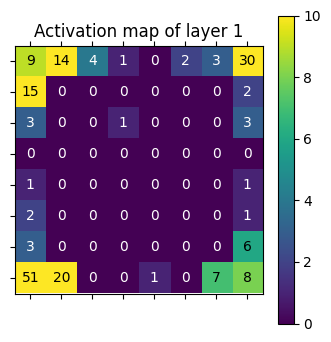

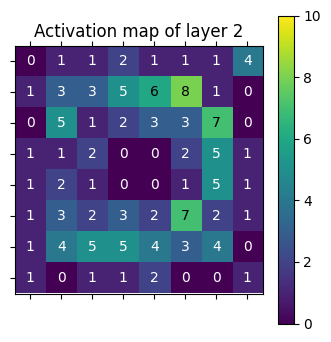

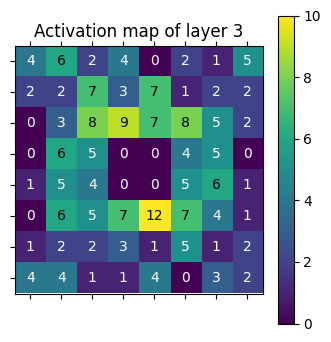

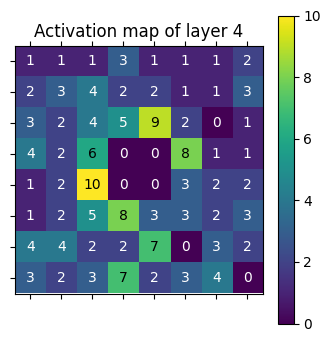

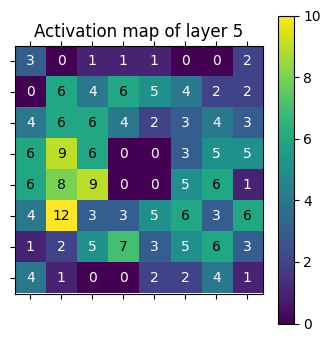

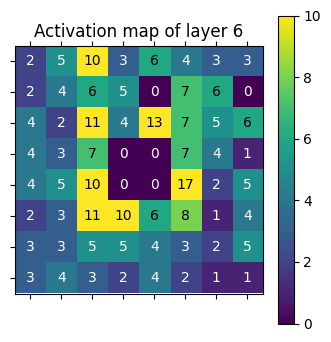

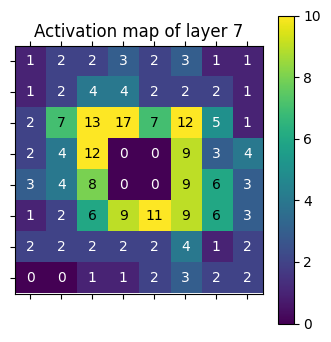

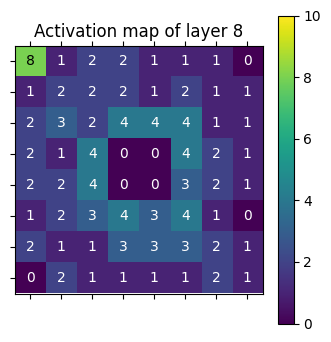

In [52]:

model_location = f"trained_model_full_{seed}.pkl"
with open(model_location, 'rb') as f:
    othello_gpt=torch.load(f, map_location=device)

for layer in layers:
    # Probe
    probe_path = f"probes/probe_layer_{layer}_{seed}_trimmed.pkl"
    full_linear_probe = torch.load(probe_path)
    my_probe_W = full_linear_probe[f'classifier.{mode}.weight'] # (64, 512)
    my_probe_W = my_probe_W.t()
    my_probe_W[:, [27, 28, 35, 36]] = 0.
    my_probe_normalised = my_probe_W / my_probe_W.norm(dim=0, keepdim=True) # torch.Size([512, 64])
    my_probe_normalised[my_probe_normalised.isnan()] = 0.

    # Weight
    weight_in_key = f"blocks.{layer}.mlp_sublayer.encode.weight"
    
    heatmaps_my = []
    w_in = othello_gpt.state_dict()[weight_in_key] # torch.Size([512, 2048])
    w_in /= w_in.norm(dim=0, keepdim=True)
    for neuron in range(0, 2048):
        neuron_weight = w_in[neuron, :]
        heatmaps_my.append((neuron_weight[:, None] * my_probe_normalised).sum(dim=0))
        
    heatmaps_my = torch.stack(heatmaps_my) # (2048, 64)
    
    activation_map = (heatmaps_my.abs()>threshold).sum(dim=0)

    activation_map = activation_map.reshape(8, 8).cpu().numpy()

    fig, ax = plt.subplots(figsize=(4, 4))
    cax = ax.matshow(activation_map, cmap="viridis", vmin=0, vmax=10)

    plt.colorbar(cax)

    
    for (i, j), val in np.ndenumerate(activation_map):
        ax.text(j, i, f"{val}", ha='center', va='center', color='white' if val <= 5 else 'black')

    plt.title(f"Activation map of layer {layer+1}")
    
    ax.set_xticks(range(8))
    ax.set_yticks(range(8))
    ax.set_xticklabels([])
    ax.set_yticklabels([])



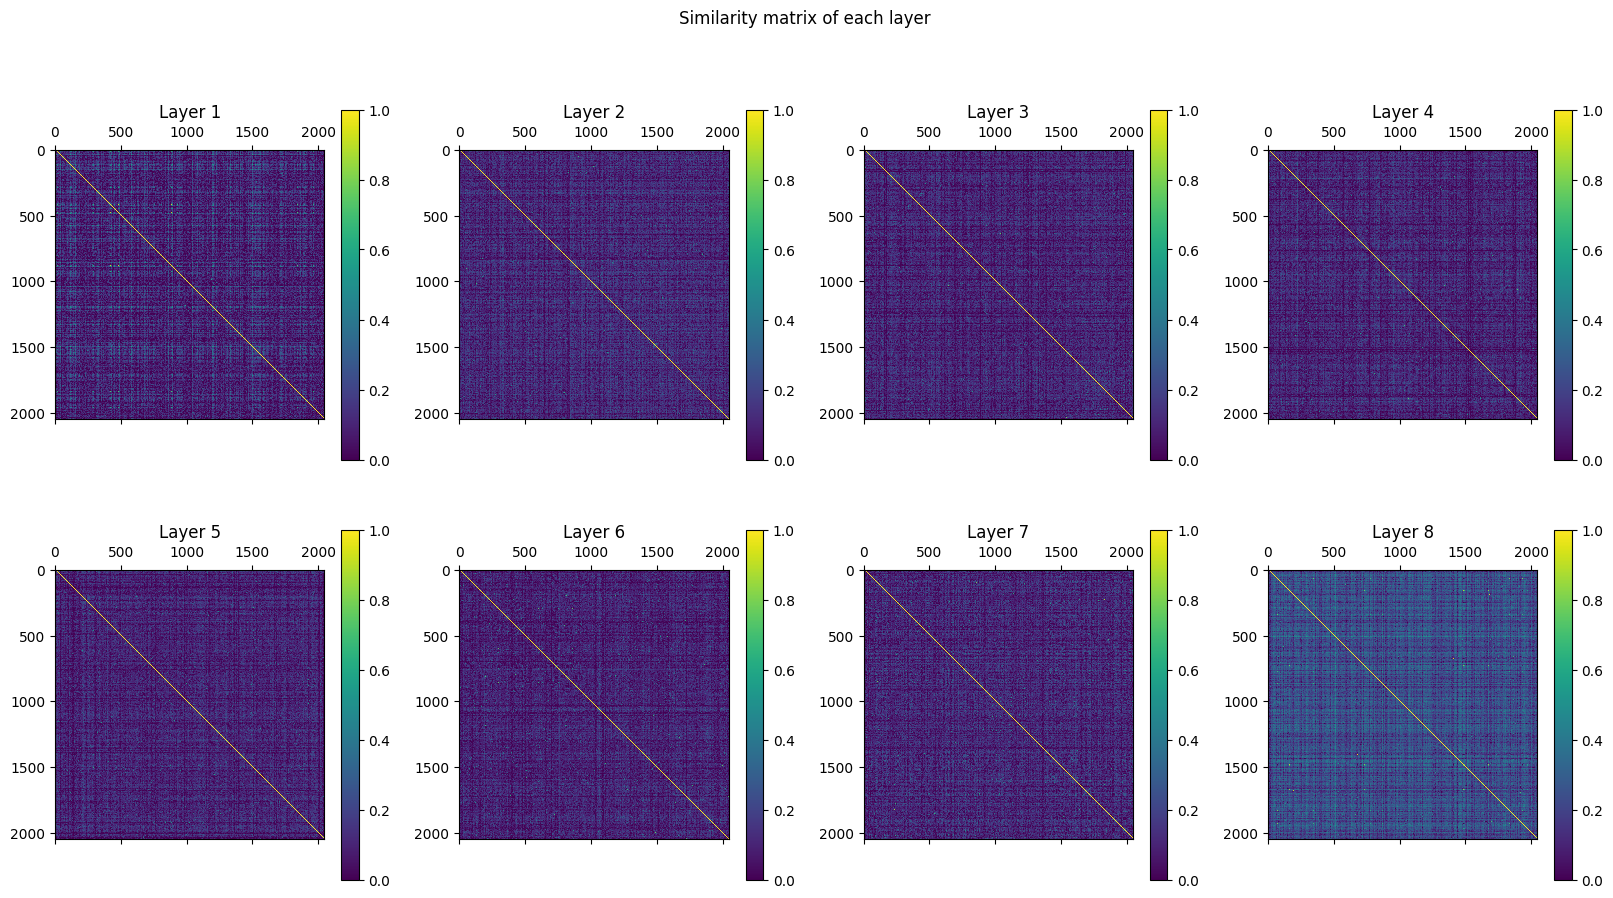

min similarity: -0.8963065147399902


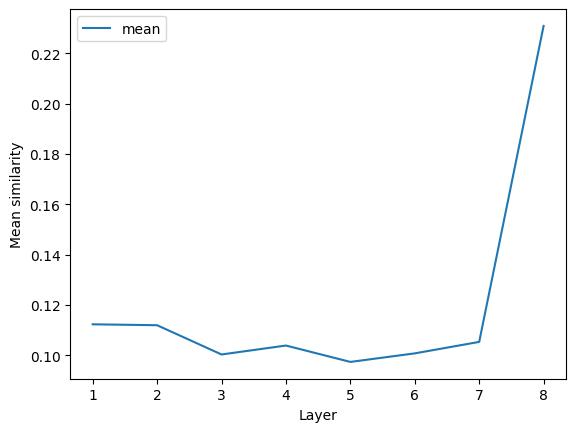

Number of neurons with similarity greater than 0.8: 74 in Layer8
Number of neurons with similarity greater than 0.8: 76 in Layer8
Number of neurons with similarity greater than 0.8: 16 in Layer8
Number of neurons with similarity greater than 0.8: 14 in Layer8
Number of neurons with similarity greater than 0.8: 52 in Layer8
Number of neurons with similarity greater than 0.8: 118 in Layer8
Number of neurons with similarity greater than 0.8: 104 in Layer8
Number of neurons with similarity greater than 0.8: 940 in Layer8


In [ ]:

model_location = f"trained_model_full_{seed}.pkl"
with open(model_location, 'rb') as f:
    othello_gpt=torch.load(f, map_location=device)

similarity_layers = []
for layer in layers:
    
    # Weight
    weight_in_key = f"blocks.{layer}.mlp_sublayer.encode.weight"
     
    heatmaps_my = []
    w_in = othello_gpt.state_dict()[weight_in_key] # torch.Size([512, 2048])
    w_in /= w_in.norm(dim=1, keepdim=True)
    
    similarity = w_in @ w_in.t()

    similarity_layers.append(similarity.cpu().numpy())

# plot simlarity_layers

fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(8):
    cax = ax[i//4, i%4].matshow(similarity_layers[i], cmap="viridis", vmin=0, vmax=1)
    ax[i//4, i%4].set_title(f"Layer {i+1}")
    plt.colorbar(cax, ax=ax[i//4, i%4])
plt.suptitle("Similarity matrix of each layer")

plt.show()

similarity_means = [np.mean(similarity - np.diag(np.diag(similarity))) for similarity in similarity_layers]
plt.plot(range(1, 9), similarity_means, label="mean")
plt.legend()
plt.xlabel("Layer")
plt.ylabel("Mean similarity")

plt.show()

threshold = 0.8
for idx, similarity in enumerate(similarity_layers):
    similarity = similarity - np.diag(np.diag(similarity))
    print(f"Number of neurons with similarity greater than {threshold}: {(similarity>threshold).sum()} in Layer{layer+1}")
